# Exploring a demonstration

This notebook shows several standard ways to interact with the demonstrations stored into the exp/run directories. 

In [9]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import matplotlib.pyplot as plt
import random
import pprint
from demonstration import Demonstration, list_demos, select_demo

In [10]:
experiment = "demonstration"
run = "freeform"

exp = Config().get_experiment(experiment, run)

***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded


### Read out all the demonstrations from a run

In [11]:
# read out all the demonstrations from a run
demos = list_demos(exp)
pprint.pprint(demos)

['2024_12_26__16_40_20', '2024_12_26__16_44_06', 'testing', 'testing2']


In [12]:
demo = select_demo(exp, force_name="testing")

###  Read out all the pictures in the demonstration

In [13]:
demo = Demonstration(exp, demo)
print(demo)


{'actions': [{'annotation': '',
              'rc-angle-target': {'0': 88.5,
                                  '1': 115.0,
                                  '2': 98.0,
                                  '3': 71.0,
                                  '4': 74.5},
              'rc-position-target': {'distance': 4.9,
                                     'gripper': 95.0,
                                     'heading': -1.5,
                                     'height': 4.9,
                                     'wrist_angle': -46.5,
                                     'wrist_rotation': 74.5},
              'rc-pulse-target': {'0': 1523.0,
                                  '1': 1737.0,
                                  '2': 1588.0,
                                  '3': 1288.0,
                                  '4': 1327.0,
                                  '5': 1075.0},
              'reward': 0.0},
             {'annotation': '',
              'rc-angle-target': {'0': 88.5,
                

Cameras found: ['dev2']
There are 597 steps in this demonstration
Random image, read as anything


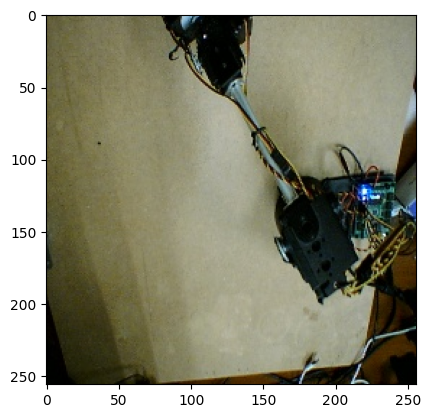

In [14]:
print(f"Cameras found: {demo.metadata['cameras']}")
print(f"There are {demo.metadata['maxsteps']} steps in this demonstration")

# if demo.metadata["stored_as_images"]:
    # pick and show a random image from a random camera
print("Random image, read as anything")
cam = random.choice(demo.metadata["cameras"])
imgno = random.randint(0, demo.metadata["maxsteps"])
sensor_readings, image = demo.get_image(imgno, camera=cam)
fig, ax = plt.subplots()
ax.imshow(image)


### Compare the same image from the video and the image

Image number: 472
Difference between image and video tensors
tensor([[[[ 0.0078, -0.0196, -0.0118,  ..., -0.0118,  0.0078,  0.0118],
          [-0.0157, -0.0078, -0.0196,  ..., -0.0157,  0.0000,  0.0039],
          [-0.0196, -0.0118, -0.0235,  ..., -0.0118, -0.0039,  0.0039],
          ...,
          [-0.0078, -0.0039, -0.0039,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0078, -0.0039, -0.0078,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0039,  0.0000, -0.0039,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0118, -0.0157, -0.0078,  ..., -0.0157,  0.0039,  0.0078],
          [-0.0118, -0.0039, -0.0157,  ..., -0.0196, -0.0039,  0.0000],
          [-0.0235, -0.0157, -0.0196,  ..., -0.0118, -0.0078,  0.0000],
          ...,
          [-0.0118, -0.0078, -0.0078,  ..., -0.0039, -0.0039, -0.0039],
          [-0.0118, -0.0078, -0.0039,  ..., -0.0039, -0.0039, -0.0039],
          [-0.0078, -0.0039,  0.0000,  ..., -0.0039,  0.0000, -0.0039]],

         [[ 0.0157, -0.0118,  0.0039,  ..

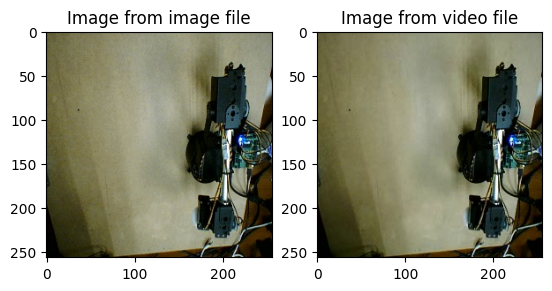

In [17]:
if demo.metadata["stored_as_images"] and demo.metadata["stored_as_video"]:
    imgno = random.randint(0, demo.metadata["maxsteps"])
    print(f"Image number: {imgno}")
    vid_tensor, vid_image = demo.get_image_from_video(imgno, camera=cam)
    img_tensor, img_image = demo.get_image(imgno+1, camera=cam)
    fig, [ax1, ax2] = plt.subplots(1,2)
    ax1.imshow(img_image)
    ax1.set_title("Image from image file")
    ax2.imshow(vid_image)
    ax2.set_title("Image from video file")
    print("Difference between image and video tensors")
    print(vid_tensor - img_tensor)
else:
    print("This demo does not have both image and video files")


### Example of how to generate video files from the image files
Note that this will delete the image files.

In [ ]:
# demo.move_to_video(delete_img_files=True)
demo.move_to_video(delete_img_files=False)

In [19]:
### How to access the actions
imgno = random.randint(0, demo.metadata["maxsteps"])
pprint.pprint(demo.actions[imgno])

{'annotation': '',
 'rc-angle-target': {'0': 78.7836603224766,
                     '1': 100.0,
                     '2': 107.0,
                     '3': 113.0,
                     '4': 80.02105036874113},
 'rc-position-target': {'distance': 5.5998284908481395,
                        'gripper': 51.42638284514174,
                        'heading': -11.216339677523393,
                        'height': 2.40383420698606,
                        'wrist_angle': -28.51804010662147,
                        'wrist_rotation': 80.02105036874113},
 'rc-pulse-target': {'0': 1415.0,
                     '1': 1571.0,
                     '2': 1688.0,
                     '3': 1755.0,
                     '4': 1389.0,
                     '5': 1728.6042573228738},
 'reward': 0.0}
